In [115]:
import os
import essentia as ess
import essentia.standard as estd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

os.chdir('..')
from utils.eval_func import *
ROOT_PATH = os.getcwd()
os.chdir('project_notebooks')

ANALYZE_SOUND_FRAME_SIZE = 2048 # Surce sound analysis frame sizes
HOP_SIZE = 256 # Parameter used by the "FrameGenerator" and "FFT" functions

DATASET_PATH = os.path.join(ROOT_PATH,'data','adc2004_full_set')

audio_path = os.path.join(DATASET_PATH, 'wav','daisy1' + '.wav')

In [100]:
def estimateF0_autoCorr(x_win,fs,minF0 = 100,maxF0 = 1000):
    '''F0 detection on a single frame using autocorrelation
    Parameters
    ----------
    x_win : numpy.array
        Windowed signal frame
    fs,minF0,maxF0 : int
        Sampling rate, minimum and maximum F0 limits
        
    Returns
    -------
    ValAC : numpy.array
    f0 : numpy.array
        Estimated f0 and autocorrelation values for those f0
    ''' 
    f0 = np.array([])
    minT0 = int(fs/maxF0)
    maxT0 = int(fs/minF0)

    Ts = range(minT0,maxT0)
    ValAC = np.array([])
    for k in Ts:
        x_win_shifted=np.hstack((np.zeros(k),x_win[:-k]))
        autoCorr=np.dot(x_win,x_win_shifted)
        ValAC = np.append(ValAC, autoCorr)
        
    f0=np.divide(fs*np.ones(len(Ts)),Ts)
    return ValAC,f0

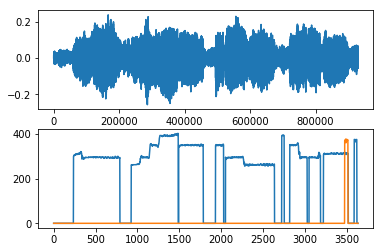

In [76]:
audio = estd.EqloudLoader(filename = audio_path, sampleRate = 44100)()
pitches = estd.MultiPitchMelodia(frameSize = ANALYZE_SOUND_FRAME_SIZE, 
                               hopSize = HOP_SIZE,
                               numberHarmonics = 10,
                               magnitudeThreshold = 40,
                               guessUnvoiced = True)(audio)
f, axarr = plt.subplots(2)
axarr[0].plot(audio)

freqs_mat = [[],[],[],[]]
for freqs in pitches:
    for _ in range(abs(len(freqs)-len(freqs_mat))):
        freqs = np.append(freqs,0)
    for i in range(len(freqs_mat)):
        freqs_mat[i].append(freqs[i])
        
for arr in freqs_mat:
    if sum(arr)/len(arr) < 0.0001: continue
    axarr[1].plot(arr)
plt.show()

#size = sum([1 for _ in estd.FrameGenerator(audio,frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE)])

#for frame,i in zip(estd.FrameGenerator(audio,frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE),range(size)):
#    if i==int(size/2):
#        x = autocorr(frame)
#        x = abs(x/max(x))
#        x[x<0.2] = 0
#        plt.plot(x)


In [138]:
audio = estd.EqloudLoader(filename = audio_path, sampleRate = 44100)()
window = estd.Windowing()

f_ac_arr = []
i = 1
for frame in estd.FrameGenerator(audio,frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE):
    framelist = []
    frame_win = window(frame)
    AC, f0 = estimateF0_autoCorr(frame_win,44100)
    AC = AC/max(AC)
    #plt.plot(f0,AC)
    peaks,_ = signal.find_peaks(AC)
    #plt.plot(f0[peaks],AC[peaks],"x")
    tuplelist = [(a,b) for a,b in zip(f0[peaks],AC[peaks])]
    tuplelist.sort(key=lambda x: x[1],reverse=True)

    framelist = [a for a,b in tuplelist]
#    if i == 500:
#        plt.plot(f0,AC)
#        peaks,_ = signal.find_peaks(AC)
#        plt.plot(f0[peaks],AC[peaks],"x")
#        framelist = f0[peaks]
#        
#        tuplelist = [(a,b) for a,b in zip(f0[peaks],AC[peaks])]
#        tuplelist.sort(key=lambda x: x[1],reverse=True)
#        
#        framelist = [a for a,b in tuplelist]
#        
#        f_ac_arr.append(framelist)
#        assert False
    f_ac_arr.append(framelist)
#    i += 1
    

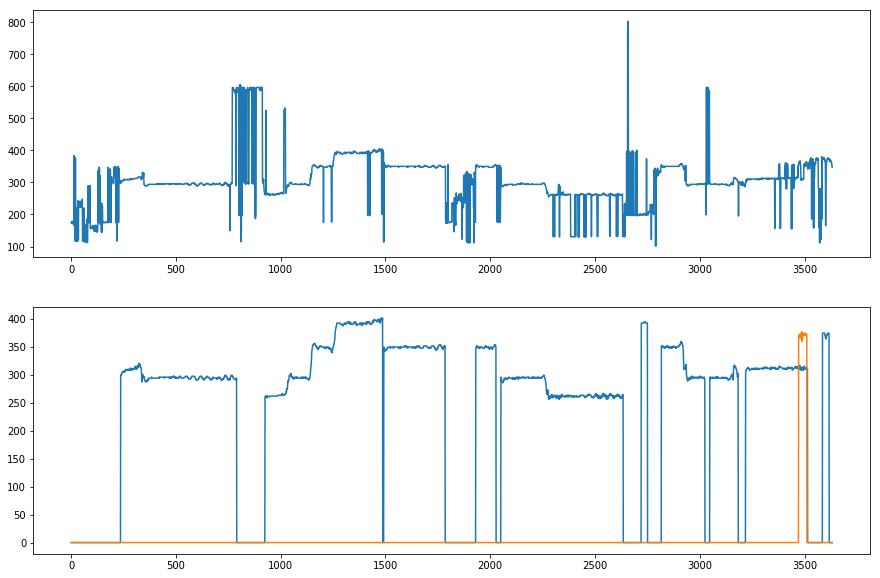

In [141]:
most_likely = [frame[0] for frame in f_ac_arr]

f, axarr = plt.subplots(2, figsize=(15,10))
axarr[0].plot(most_likely)

for arr in freqs_mat:
    if sum(arr)/len(arr) < 0.0001: continue
    axarr[1].plot(arr)
plt.show()

In [142]:
f_ac_arr[2500]

[262.5,
 243.64640883977901,
 131.25,
 282.69230769230768,
 102.55813953488372,
 208.01886792452831,
 107.2992700729927,
 150.0,
 198.64864864864865,
 112.21374045801527,
 400.90909090909093,
 158.63309352517985,
 355.64516129032256,
 168.9655172413793,
 182.23140495867767,
 469.14893617021278,
 760.34482758620686,
 588.0]

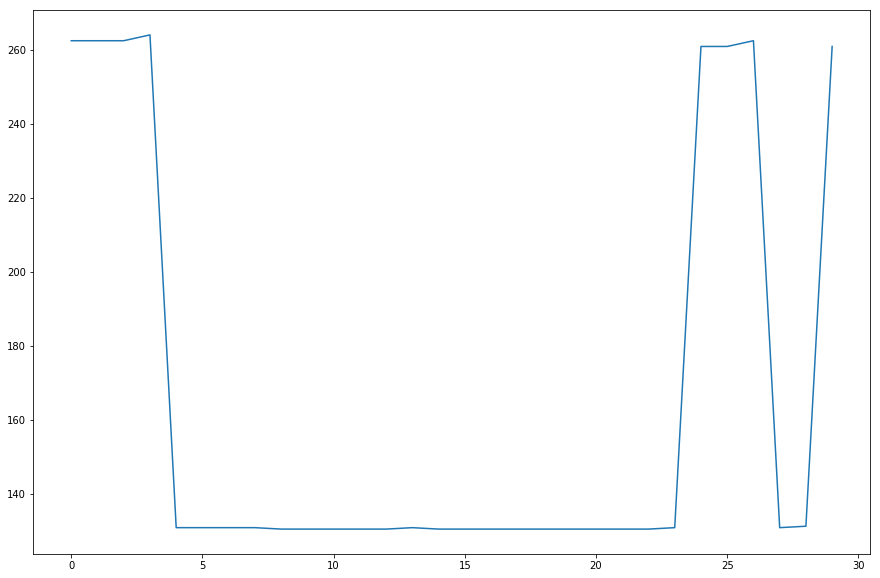

In [146]:
plt.figure(figsize = (15,10))
plt.plot(most_likely[2380:2410])
plt.show()